#### 사이킷런 래퍼 XGBoost의 개요 및 적용

- XGBClassifier는 기존 사이킷런에서 일반적으로 사용하는 하이퍼 파라미터와 호환성을 유지하기 위해 기존의 xgboost 모듈에서 사용하던 하이퍼 파라미터 몇개를 변경함

eta → learning rate

sub_sample → subsample

lambda → reg_lambda

alpha → red_alpha

- XGBoost API에서는 num_boost_round 적용, 사이킷런 래퍼 XGBClassifier는 n_estimators 적용

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(features, columns=dataset.feature_names)
cancer_df['target'] = labels

X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

In [3]:
from xgboost import XGBClassifier

#warning메세지를 없애기 위해 eval_metric값을 XGBClassifier 생성인자로 입력
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric = 'logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [6]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1:0.9744, AUC: 0.9954


- 위스콘신 데이터 자체가 크기가 작은데 검증데이터를 분리하거나 교차검증을 적용할 때 성능 수치가 불안정함

- 따라서, 파이썬 래퍼 XGBoost로 학습할 때보다 더 좋은 평가가 나옴

#### 사이킷런 래퍼 XGBoost에서 조기중단 수행하기

- 조기 중단 관련 파라미터를 fit()에 입력하면됌

early_stopping_rounds: 반복 횟수 정하는
eval_metric: 조기중단을 위한 평가지표
eval_set: 성능평가를 수행할 데이터셋

In [8]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[16]	validation_0-logloss:0.27651	validation_1-logloss:0.39887
[17]	validation_0-logloss:0.26389	validation_1-logloss:0.39050
[18]	validation_0-logloss:0.25210	validation_1-logloss:0.38254
[19]	validation_0-logloss:0.24123	validation_1-logloss:0.37393
[20]	validation_0-logloss:0.23076	validation_1-logloss:0.36789
[21]	validation_0-logloss:0.22091	validation_1-logloss:0.36017
[22]	validation_0-logloss:0.21155	validation_1-logloss:0.35421
[23]	validation_0-logloss:0.20263	validation_1-logloss:0.34683
[24]	validation_0-logloss:0.19434	validation_1-logloss:0.34111
[25]	validation_0-logloss:0.18637	validation_1-logloss:

In [9]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1:0.9677, AUC: 0.9933


- 조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 수 있음

#### 조기 중단값을 10으로 설정하고 측정해보자

In [10]:
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[16]	validation_0-logloss:0.27651	validation_1-logloss:0.39887
[17]	validation_0-logloss:0.26389	validation_1-logloss:0.39050
[18]	validation_0-logloss:0.25210	validation_1-logloss:0.38254
[19]	validation_0-logloss:0.24123	validation_1-logloss:0.37393
[20]	validation_0-logloss:0.23076	validation_1-logloss:0.36789
[21]	validation_0-logloss:0.22091	validation_1-logloss:0.36017
[22]	validation_0-logloss:0.21155	validation_1-logloss:0.35421
[23]	validation_0-logloss:0.20263	validation_1-logloss:0.34683
[24]	validation_0-logloss:0.19434	validation_1-logloss:0.34111
[25]	validation_0-logloss:0.18637	validation_1-logloss:0.33634
[26]	validation_0-logloss:0.17875	validation_1-logloss:0.33082
[27]	validation_0-logloss:0.17167	validation_1-logloss:0.32675
[28]	validation_0-logloss:0.16481	validation_1-logloss:

- 103번째까지만 반복하다 종료됐는데, 93번째에 logloss가 가장 낮고 10번 반복하는 동안 성능평가지수가 향상되지 않아서 종료됌

- 이렇게 예측한 정확도는 조기 중단 횟수가 50일때보다 낮음

#### 피처 중요도를 시각화해보자

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

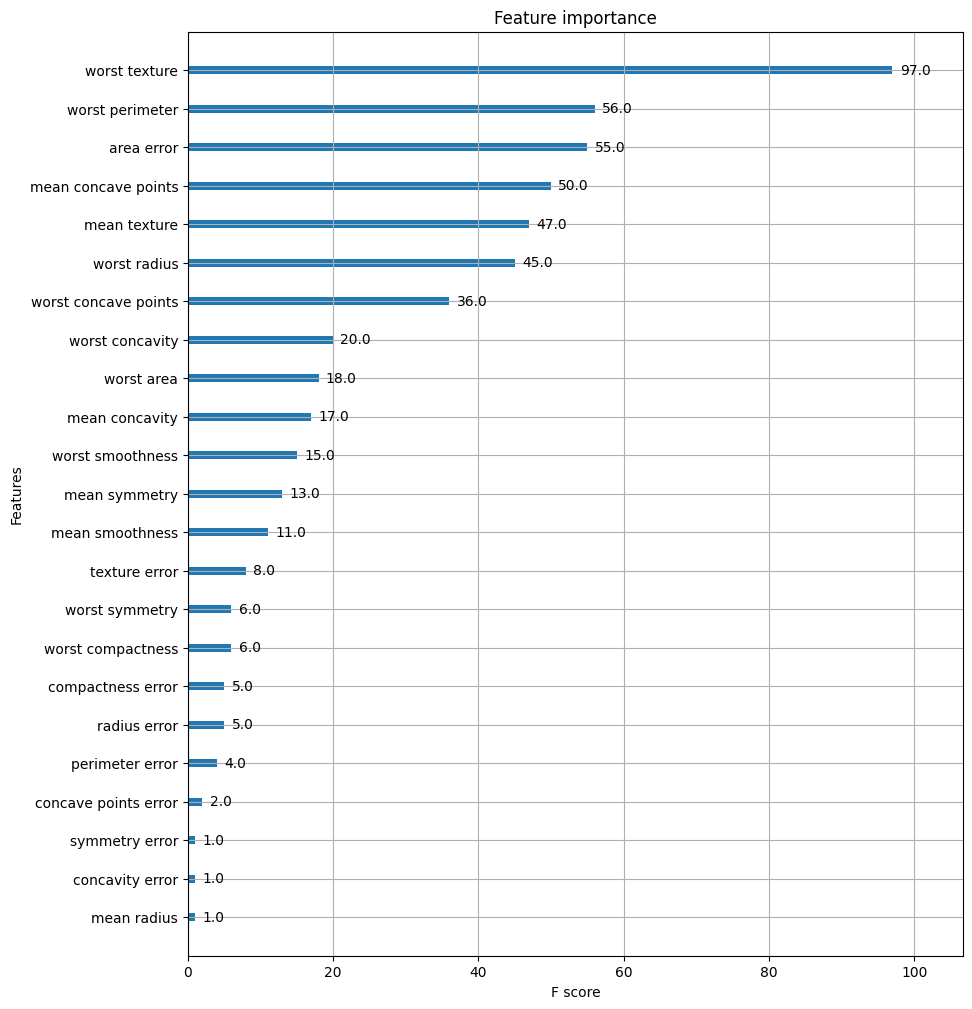

In [11]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)